<a href="https://colab.research.google.com/github/AKMADOU/projet-1/blob/main/ADOU_Kouam%C3%A9_Mathurin_LR_with_Regularization___Students_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature selection with L1 Regularization

* Consider a supervised learning setting where you have data $\mathcal{D} = \{(X, Y)\}$, where $X \in \mathbb{R}^{NXD}$. $N$  - num of datapoints and $D$ - num of features. Many of the features may be irrelevant for the task at hand.
* Typically when there are more features than samples, ie. $D >> N$, a simple linear regression model is prone to overfit.
* As we have seen before, regularization is one of the tools in our toolbox to combat overfitting. Here we will see how they do that and how $L1$ regularization can be used for feature selection.

## Tasks

1. Load the data "cancer_reg.csv" data.
2. Preprocess your data particularly making sure there are no nan values.
3. Since we want to study overfitting and how to solve it, we are going to add correlated features to our data to increase the number of features. These new features are usless, we will see how to remove them with $L1$ regularization. We will take only small portion of the data for training (It could be 20% for training). This will make our model overfit, later on we will regularize the model to solve the overfitting.
4. Define your linear regression model with and without regularization ($L1$ and $L2$)
5. Train and test your linear regression models (without regularization) till it overfits the data. Plot the learning curves for training and testing (You may ignore loss values for the first 10 epochs)
6. Train and test again with $L1$ regularization and visually inspect the effects. Plot the weights for each model (using matplotlib stem plot). Do you see any difference between them?
7. In the case of the $L1$ **(Lasso) **regularization, set a small threshold and remove all features of the data corresponding to the weights with values below this threshold. Train a new model with remaining features (with or without regularization)
8. Train and test again with $L2$ regularization **(Ridge)** and visually inspect the effects. Plot the weights for each model (using matplotlib stem plot). Do you see any difference between them?
9. Train and test again with $L1$ + $L2$ regularization **(Elastic Net)** and visually inspect the effects. Plot the weights for each model (using matplotlib stem plot). Do you see any difference between them?


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load the data "cancer_reg.csv" data from here. A slightly modified copy will be shared with you on workplace. Target is labeled "TARGET_deathRate".

#Dataset Class:

It is always recommended to create a seperate class to prepare the data. Usually we use the Dataset class for:


1.   Downloading the data, if needed.
2.   Preprocessing the data.
3.   Spliting the data.




In [45]:
class Dataset:
  def __init__(self, path, test_size=0.85):
    self.test_size = test_size
    if path==None:
        self.train_inputs = []
        self.test_inputs = []
        self.train_targets = []
        self.test_targets = []
    else:
        self.initialize(path)
    
  def initialize(self, path):
    data = pd.read_csv(path,  encoding='latin-1')
    #Fill all the NAN values with the mean
    for col in data.columns:
      if data[col].isna().sum()!=0:
        data[col][data[col].isna()] = data[col].mean()
        
    data = data.drop(['Geography', 'binnedInc'], axis=1)
    
    target = data["TARGET_deathRate"].values
    inputs = data.drop("TARGET_deathRate", axis=1)


    #here we add more features
    for col in inputs.columns:
      for i in range(2,10):
        new_col = f'{col}_{i}' 
        inputs[new_col] =  inputs[col]**i

    inputs = inputs.values
    inputs = inputs/inputs.max(axis=0)
    self.target = target
    self.inputs = inputs
    
    #Shuffle before splitting the data
    indices = np.arange(len(self.target))
    np.random.shuffle(indices)
    test_num_points = int(self.test_size * len(indices))
    test_indices = indices[:test_num_points]
    train_indices = indices[test_num_points:]

    self.train_inputs = self.inputs[train_indices]
    self.test_inputs = self.inputs[test_indices]
    self.train_targets = self.target[train_indices]
    self.test_targets = self.target[test_indices]
  


    

In [46]:
dataset = Dataset("cancer_reg.csv") #"cancer-mortality-rate.csv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [47]:
# data = pd.read_csv('cancer_reg.csv',  encoding='latin-1')
# data.head(5)

In [48]:
print("train inputs shape: ",dataset.train_inputs.shape)
print("test inputs shape: ",dataset.test_inputs.shape)

train inputs shape:  (458, 279)
test inputs shape:  (2589, 279)


# Linear Regression With Regularization:

In [54]:
class LinearRegressionModel:
  def __init__(self, dataset, lambda1 = 0.9, lambda2 = 0.01, lr = 0.001, epochs=10000):
    self.dataset = dataset
    self.lambda1 = lambda1
    self.lambda2 = lambda2
    self.learning_rate = lr
    self.epochs = epochs
    #initialize the parameters randomly
    d = dataset.train_inputs.shape[1] # number of column features
    self.theta = np.random.randn(d+1)

  def add_one(self, x):
    ones = np.ones((len(x),1))
    x =np.concatenate([x,ones], axis =1) # concatenate the column
    return x
  def grad(self,w):
    val=[]
    for i in w:
      if i<0:
        val.append(-1)
      else:
        val.append(1)
    return np.array(val)#.reshape(-1,1)    

  def predict(self, x):
    y_pred = x @ self.theta
    return y_pred
    

  def compute_mse_loss(self, y_true, y_pred):
    return ((y_true -y_pred)**2).mean()
  

  def plot_loss_and_params(self, train_losses, test_losses):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
    ax1.plot(train_losses[10:], label="train-loss")
    ax1.plot(test_losses[10:], label="test-loss")
    ax1.set_title('loss')
    ax2.stem(self.theta, use_line_collection=True)
    ax2.set_title('params values')
    ax3.hist(self.theta, 50, facecolor='g', alpha=0.75)
    ax3.set_title('params histogram')

    plt.show()


  def train(self, batch_size=32, plot=True):
    train_losses = []
    test_losses = []


    for epoch in range(self.epochs):

      indices = np.arange(len(self.dataset.train_inputs))
    
      np.random.shuffle(indices)
      
      self.dataset.train_inputs = self.dataset.train_inputs[indices] 
      self.dataset.train_targets = self.dataset.train_targets[indices] 
      # compute the number of batches
      number_of_batches = len(self.dataset.train_inputs)//batch_size 
      # self.theta = np.zeros((self.dataset.train_inputs.shape[1]))
      epoch_losses =[]
     
      for batch_number in range(number_of_batches):
        x =self.dataset.train_inputs[batch_number*batch_size:(batch_number+1)*batch_size]
        y =self.dataset.train_targets[batch_number*batch_size:(batch_number+1)*batch_size]
        x=self.add_one(x)

        y_pred = self.predict(x)
        gradient = x.T @ (self.predict(x) - y)+2*self.lambda2*self.theta +self.lambda1*self.grad(self.theta)
        #y_pred =self.predict(x)

        self.theta = self.theta - gradient*self.learning_rate
        

        loss = self.compute_mse_loss(y_pred,y)
        epoch_losses.append(loss)
      # THE END OF EPOCH
      train_losses.append(np.mean(epoch_losses))


      test_inputs = self.dataset.test_inputs
      test_inputs = self.add_one(test_inputs)
      y_pred_test = self.predict(test_inputs)
      test_loss = self.compute_mse_loss(self.dataset.test_targets, y_pred_test)
      test_losses.append(test_loss)
    if epoch %100 ==0:
        print(f"Epoch: {epoch} train_loss: {train_losses[-1]:.4f} test_loss:{test_losses[-1]:.4f}")
    if plot:
      self.plot_loss_and_params(train_losses, test_losses)

In [55]:
model = LinearRegressionModel(dataset, lambda2=0.0, lambda1=0.0,  lr = 0.001, epochs=10000)

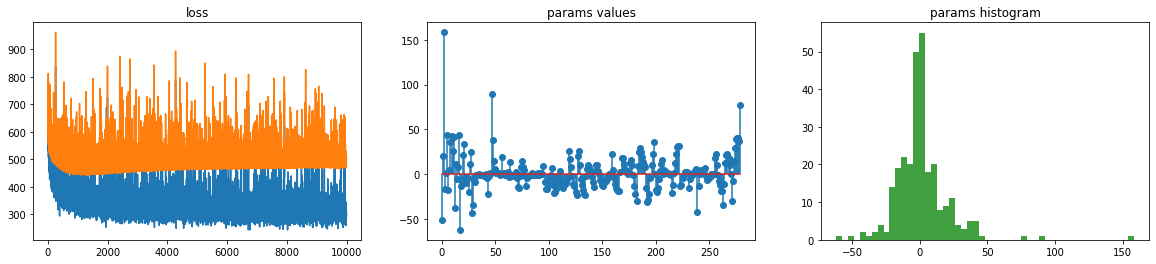

In [56]:
model.train(batch_size=128)

##L1 Regularization (Lasso Reg):
Lasso stands for Least Absolute **Shrinkage** and **Selection** Operator.

Lasso Regression is useful when some of the features are useless. It will set many of the parameters to zero.

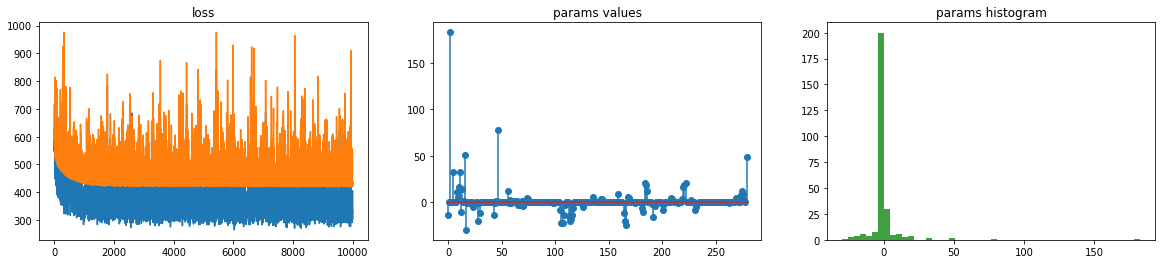

In [57]:
# The larger your value of l1, the more likely some of the coefficients get closer to zero
model = LinearRegressionModel(dataset, lambda2=0.0, lambda1=2.5, lr = 0.001, epochs=10000)
model.train(batch_size=128)
#If you look the stem plot we will find that many of the parameters have values ~0

Epoch: 0 train - loss: 19413.2269 test-loss: 1341.3726
Epoch: 1000 train - loss: 343.5552 test-loss: 428.3262
Epoch: 2000 train - loss: 323.6233 test-loss: 424.6431
Epoch: 3000 train - loss: 326.3975 test-loss: 420.1133
Epoch: 4000 train - loss: 307.7951 test-loss: 423.8128
Epoch: 5000 train - loss: 314.0287 test-loss: 420.6493
Epoch: 6000 train - loss: 358.9282 test-loss: 422.9923
Epoch: 7000 train - loss: 301.5955 test-loss: 422.2581
Epoch: 8000 train - loss: 300.1389 test-loss: 421.7515
Epoch: 9000 train - loss: 335.4946 test-loss: 424.2120


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


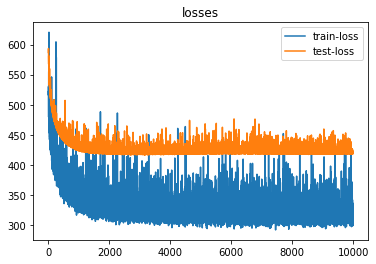

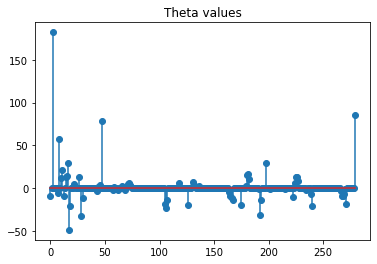

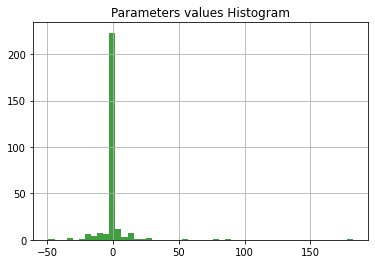

In [ ]:
# The larger your value of l1, the more likely some of the coefficients get closer to zero
model = LinearRegressionModel(dataset, l2=0.0, l1=2.5, lr = 0.001, epochs=10000)
model.train(batch_size=128)
#If you look the stem plot we will find that many of the parameters have values ~0

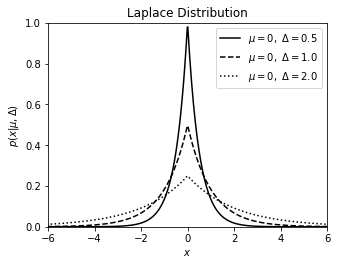

In [ ]:
#the parameters follow a laplace distribution with small var
import numpy as np
from scipy.stats import laplace
from matplotlib import pyplot as plt


delta_values = [0.5, 1.0, 2.0]
linestyles = ['-', '--', ':']
mu = 0
x = np.linspace(-10, 10, 1000)
fig, ax = plt.subplots(figsize=(5, 3.75))

for delta, ls in zip(delta_values, linestyles):
    dist = laplace(mu, delta)

    plt.plot(x, dist.pdf(x), ls=ls, c='black',
             label=r'$\mu=%i,\ \Delta=%.1f$' % (mu, delta))

plt.xlim(-6, 6)
plt.ylim(0, 1.0)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\Delta)$')
plt.title('Laplace Distribution')

plt.legend()
plt.show()

### Features Selection with L1 Regulariztion:

In [58]:
threshold = 0.005
model.drop_features(threshold)

AttributeError: ignored

In [ ]:
model.train()

In [ ]:
model.theta.shape

In [ ]:

model.dataset.train_inputs.shape

##L2 Regularization (Ridge Reg):

When most of the features are useful, Ridge reg will shrink the parameters but it will not remove them totally.

Epoch: 0 train - loss: 22481.0433 test-loss: 1466.8334
Epoch: 1000 train - loss: 348.1458 test-loss: 450.6485
Epoch: 2000 train - loss: 385.6935 test-loss: 448.1207
Epoch: 3000 train - loss: 348.5145 test-loss: 447.4030
Epoch: 4000 train - loss: 367.2970 test-loss: 450.6947


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


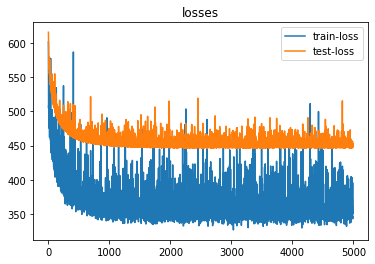

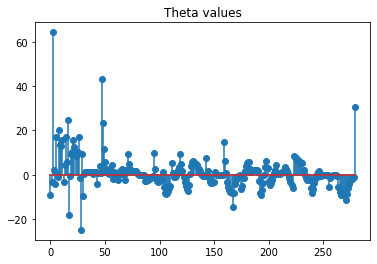

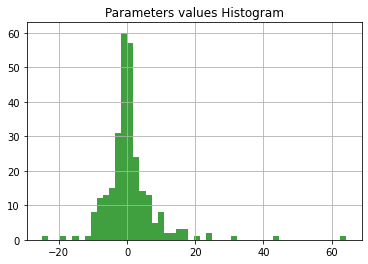

In [ ]:
# The larger your value of l2, the more likely your coefficients get smaller
model = LinearRegressionModel(dataset, l2=0.4, l1=0.0, lr=0.001, epochs=5000)
model.train(batch_size=128)

## Elastic Net

Elastic net combines both ridge reg and lasso reg

Epoch: 0 train - loss: 22704.1667 test-loss: 1278.5960
Epoch: 1000 train - loss: 356.4659 test-loss: 441.7069
Epoch: 2000 train - loss: 330.8596 test-loss: 435.3702
Epoch: 3000 train - loss: 322.3842 test-loss: 435.6948
Epoch: 4000 train - loss: 323.8022 test-loss: 432.8343
Epoch: 5000 train - loss: 329.1918 test-loss: 435.2883
Epoch: 6000 train - loss: 331.3087 test-loss: 436.3030
Epoch: 7000 train - loss: 432.1175 test-loss: 448.2826
Epoch: 8000 train - loss: 345.1974 test-loss: 434.3930
Epoch: 9000 train - loss: 348.3900 test-loss: 436.6164


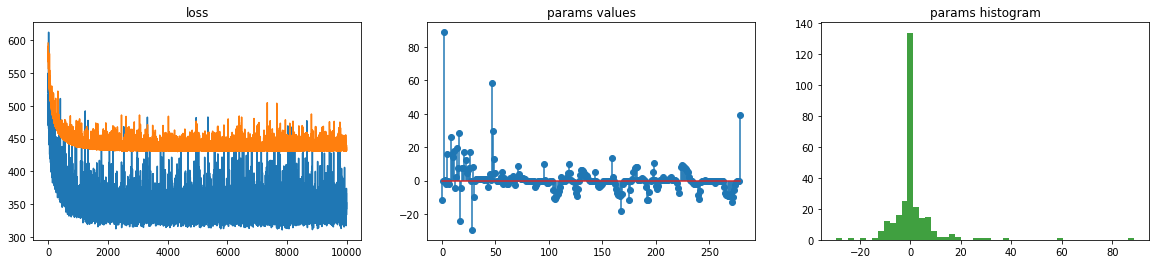

In [ ]:
model = LinearRegressionModel(dataset, l2=0.2, l1=0.8, lr = 0.001, epochs=10000)
model.train(batch_size=128)